In [1]:
from collections import Counter
from nltk.corpus import stopwords
from nltk import tokenize
from torch.utils.data import Dataset

import string
import nltk
import os
import random
import numpy as np
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F


# Read Data

In [2]:
imdb_dir = '/Users/xueyingwang/Documents/DS1011_NLP/HW/HW1/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
test_dir = os.path.join(imdb_dir, 'test')

def read_test_train_dir(path,):
    labels = []
    texts = []
    for label_type in ['neg', 'pos']:
        dir_name = os.path.join(path, label_type)
        for fname in os.listdir(dir_name):
            if fname[-4:] == '.txt':
                f = open(os.path.join(dir_name, fname))
                texts.append(f.read())
                f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)
    return texts,labels

# Split train/val/test dataet

In [3]:
train_split = 20000
train_text, train_labels = read_test_train_dir(train_dir)
training_set = list(zip(train_text,train_labels))
random.shuffle(training_set)

train_data,train_targets = zip(*training_set[:train_split])
val_data, val_targets = zip(*training_set[train_split:])
test_data,test_targets =  read_test_train_dir(test_dir)

print ("Train dataset size is {}".format(len(train_data)))
print ("Val dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [25]:
loss_history = {}
validation_acc_history = {}
after_train_val_acc ={}

Codes above only run one time making sure we use fixed training/val/test set.

# Parameters below are used to tune later. 

Run the following codes multiple times based on change in parameters. (manual selection)

In [968]:
#tokenize schemes
lower_case=True 
remove_punctuation = True
remove_stopwords = True

#model paramters
n_gram = 1 
max_vocab_size = 100000
emb_dim = 150
MAX_SENTENCE_LENGTH = 500

#optmizize parameters
learning_rate = 0.001
num_epochs = 8
step_lr = False
criterion = torch.nn.CrossEntropyLoss()   
BATCH_SIZE = 32
opt = 'Adam'

#best setting for final version
best = False

In [969]:
#create appropriate name to save training history
def paramter_combination_name(lower, punctuations, stopwords,ngram, vocab, 
                              lr, epoch, opt, batch, step_lr, max_sentence):
    name = 'ngr_'+str(ngram)+'_vocab_'+str(vocab)+'_emb_'+str(emb_dim)+\
            '_lr_'+ str(lr)[-3:] + '_epoch_'+str(epoch)+'_'+opt\
            +'_batch_'+str(batch)+'_max_sent_'+str(max_sentence)
    if lower:
        name +='_lower'
    if punctuations:
        name += '_punct'
    if stopwords:
        name += '_stopw'
    if step_lr:
        name +='_step_lr_2_gamma_.5'
    return name

current_parameter_setting = paramter_combination_name(lower_case, remove_punctuation, 
                          remove_stopwords,n_gram, max_vocab_size,
                          learning_rate, num_epochs, opt, BATCH_SIZE, step_lr, MAX_SENTENCE_LENGTH)
if best:
    current_parameter_setting ='best_model'
loss_history[current_parameter_setting] = []
validation_acc_history[current_parameter_setting] = []
print(current_parameter_setting)

ngr_1_vocab_100000_emb_150_lr_001_epoch_8_Adam_batch_32_max_sent_500_lower_punct_stopw


# Tokenization 

In [484]:
tokenizer = nltk.word_tokenize
punctuations = string.punctuation
stop_words = set(stopwords.words('english'))

def text_tokenize_schemes(text, lower_case, remove_punctuation, remove_stopwords):
    text = text.replace('<br />', '')
    if lower_case:
        text = text.lower()
    tokens = tokenizer(text)
    if remove_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    if remove_punctuation:
        tokens = [token for token in tokens if (token not in punctuations)]
    return tokens

def extract_n_grams(text, n_gram, *args):
    all_ngrams = []
    tokens = text_tokenize_schemes(text, *args)
    for n in range(n_gram):
        for i in range(len(tokens)-n):
            current_n_gram = ' '.join(tokens[i:i+1+n])
            all_ngrams +=[current_n_gram]
    return all_ngrams

def tokenize_dataset(dataset, n_gram, *args):
    token_dataset = []
    all_tokens = []
    for sample in dataset:
        tokens = extract_n_grams(sample, n_gram, *args)
        token_dataset.append(tokens)
        all_tokens += tokens
    return token_dataset, all_tokens

# val set tokens
print ("Tokenizing val data")
val_data_tokens, _ = tokenize_dataset(val_data, n_gram, lower_case, remove_punctuation, remove_stopwords)

# test set tokens
print ("Tokenizing test data")
test_data_tokens, _ = tokenize_dataset(test_data, n_gram, lower_case, remove_punctuation, remove_stopwords)

# train set tokens
print ("Tokenizing train data")
train_data_tokens, all_train_tokens = tokenize_dataset(train_data, n_gram, lower_case, remove_punctuation,remove_stopwords)


Tokenizing val data
Tokenizing test data
Tokenizing train data


In [485]:
# double checking
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))

print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 2549390


# Build Vocabulary

In [486]:
PAD_IDX = 0
UNK_IDX = 1

def build_vocab(all_tokens):
    # Returns:
    # id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # token2id: dictionary where keys represent tokens and corresponding values represent indices
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2,2+len(vocab)))) 
    id2token = ['<pad>', '<unk>'] + id2token
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token

token2id, id2token = build_vocab(all_train_tokens)

In [487]:
# Lets check the dictionary by loading random token from it
random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]
print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 18279 ; token diggers
Token diggers; token id 18279


In [488]:
# convert token to id in the dataset
def token2index_dataset(tokens_data):
    indices_data = []
    for tokens in tokens_data:
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in tokens]
        indices_data.append(index_list)
    return indices_data

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

# double checking
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


# DataLodaer

In [835]:
class IDMBData(Dataset):

    def __init__(self, data_list, target_list):
        """
        @param data_list: list of newsgroup tokens 
        @param target_list: list of newsgroup targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.target_list[key]
        return [token_idx, len(token_idx), label]

def idmb_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all 
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []

    for datum in batch:
        label_list.append(datum[2])
        length_list.append(datum[1])
    # padding
    for datum in batch:
        padded_vec = np.pad(np.array(datum[0]), 
                                pad_width=((0,MAX_SENTENCE_LENGTH-datum[1])), 
                                mode="constant", constant_values=0)
        data_list.append(padded_vec)
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

train_dataset = IDMBData(train_data_indices, train_targets)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=idmb_collate_func,
                                           shuffle=True)

val_dataset = IDMBData(val_data_indices, val_targets)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=idmb_collate_func,
                                           shuffle=False)

test_dataset = IDMBData(test_data_indices, test_targets)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=idmb_collate_func,
                                           shuffle=False)



# Model

In [836]:
class BagOfWords(nn.Module):
    """
    BagOfWords classification model
    """
    def __init__(self, vocab_size, emb_dim):
        """
        @param vocab_size: size of the vocabulary. 
        @param emb_dim: size of the word embedding
        """
        super(BagOfWords, self).__init__()
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim,20)
    
    def forward(self, data, length):
        """
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a 
            review that is represented using n-gram index. Note that they are padded to have same length.
        @param length: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in the data.
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        
        # return logits
        out = self.linear(out.float())
        return out

model = BagOfWords(len(id2token), emb_dim)

# TRAIN

In [837]:
if opt == 'Adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
else:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
if step_lr:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
# Function for testing the model
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    result = []
    model.eval()
    for data, lengths, labels in loader:
        data_batch, length_batch, label_batch = data, lengths, labels
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
        #save the result of best model on the validaation set
        result.append([labels.numpy(), predicted.numpy()])
    return (100 * correct / total),result

for epoch in range(num_epochs):
    if step_lr:
        scheduler.step()
    for i, (data, lengths, labels) in enumerate(train_loader):     
        model.train()
        data_batch, length_batch, label_batch = data, lengths, labels
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and i % 100 == 0:
            # validate
            val_acc,_ = test_model(val_loader, model)
            validation_acc_history[current_parameter_setting].append(val_acc)
            loss_history[current_parameter_setting].append(loss.item())
            print('Epoch: [{}/{}], Step: [{}/{}], Loss: {} Validation Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader),loss.item(), val_acc))


Epoch: [1/8], Step: [101/625], Loss: 1.2589449882507324 Validation Acc: 59.16
Epoch: [1/8], Step: [201/625], Loss: 0.7366144061088562 Validation Acc: 65.76
Epoch: [1/8], Step: [301/625], Loss: 0.651820719242096 Validation Acc: 72.48
Epoch: [1/8], Step: [401/625], Loss: 0.6059085726737976 Validation Acc: 75.34
Epoch: [1/8], Step: [501/625], Loss: 0.5199303030967712 Validation Acc: 78.62
Epoch: [1/8], Step: [601/625], Loss: 0.45231765508651733 Validation Acc: 81.72
Epoch: [2/8], Step: [101/625], Loss: 0.44827476143836975 Validation Acc: 83.4
Epoch: [2/8], Step: [201/625], Loss: 0.32144084572792053 Validation Acc: 84.72
Epoch: [2/8], Step: [301/625], Loss: 0.3098317086696625 Validation Acc: 85.02
Epoch: [2/8], Step: [401/625], Loss: 0.278302937746048 Validation Acc: 86.32
Epoch: [2/8], Step: [501/625], Loss: 0.25637274980545044 Validation Acc: 87.12
Epoch: [2/8], Step: [601/625], Loss: 0.40305641293525696 Validation Acc: 87.88
Epoch: [3/8], Step: [101/625], Loss: 0.22536370158195496 Valid

In [759]:
print ("After training for {} epochs".format(num_epochs))
print ("Val Acc {}".format(test_model(val_loader, model)))

after_train_val_acc[current_parameter_setting] = test_model(val_loader, model)

After training for 8 epochs
Val Acc 90.2


# Parameter Tuning


tokenization schemes:

lower case, remove punctuation, remove stop words

paramters:
1. n-grams (n=1,2,3,4)
2. vocab size (10,000; 50,000; 100,000)
3. embedding size (100, 150, 200)
4. learning rate (0.001, 0.01, 0.1) / with lr=0.01 + StepLR(step_size=2, gamma=0.5)
5. optimizer (SGD & Adam)
6. max sentence length (100, 200, 500)
7. batch size (32, 64, 128)
8. num_epoch (5, 8, 10)

 

In [832]:
# There are 30+ parameter combinations. 
after_train_val_acc

{'ngr_2_vocab_10000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct': 85.22,
 'ngr_1_vocab_10000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct': 85.46,
 'ngr_1_vocab_10000_emb_100_lr_01_epoch_5_Adam_batch_32_lower': 85.02,
 'ngr_1_vocab_10000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct_stopw': 86.04,
 'ngr_1_vocab_10000_emb_100_lr_01_epoch_5_Adam_batch_32': 84.6,
 'ngr_2_vocab_10000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct_stopw': 85.14,
 'ngr_3_vocab_10000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct': 84.16,
 'ngr_4_vocab_10000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct': 84.48,
 'ngr_2_vocab_20000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct': 85.14,
 'ngr_2_vocab_50000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct': 86.58,
 'ngr_2_vocab_100000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct': 87.74,
 'ngr_1_vocab_100000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct_stopw': 87.96,
 'ngr_1_vocab_50000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct_stopw':

# Ablation Study

In [795]:
#create function to plot training loss and validation acc for very combition of paramters
import matplotlib.pyplot as plt
import pandas as pd
f = plt.figure(figsize=(20,7))
def plot_training_curve(setting):
    if setting == 'token_scheme':
        fixed = 'ngr_1_vocab_10000_emb_100_lr_01_epoch_5_Adam_batch_32'
        keys = [key for key in after_train_val_acc.keys() if fixed in key]
        title = 'Tokenization Schemes with 1 gram'
    if setting == 'n_grams':
        fixed = '_vocab_10000_emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct'
        keys = [key for key in after_train_val_acc.keys() if fixed in key and '_stopw' not in key]
        title = 'n_gram Variation'
    if setting == 'vocab_size':
        fixed = 'emb_100_lr_01_epoch_5_Adam_batch_32_lower_punct_stopw'
        keys = [key for key in validation_acc_history.keys() if fixed in key 
                and 'ngr_1' in key and 'decay_rate' not in key]
        title = 'Vocab Size'
    if setting == 'embedd_size':
        fixed = 'lr_01_epoch_5_Adam_batch_32_lower_punct_stopw'
        keys = [key for key in after_train_val_acc.keys() if fixed in key 
                and 'ngr_1_vocab_100000' in key and 'step_lr_2_gamma' not in key]
        title = 'Embedding Size'
    if setting == 'learning_rate':
        fixed = 'epoch_5_Adam_batch_32_lower_punct_stopw'
        keys = [key for key in after_train_val_acc.keys() if fixed in key 
                and 'ngr_1_vocab_100000_emb_150_' in key]
        title = 'Learning Rate'
    if setting == 'optimizer':
        fixed = 'ngr_1_vocab_100000_emb_150_lr_001_epoch_5_'
        keys = [key for key in after_train_val_acc.keys() if fixed in key 
            and 'batch_32_lower_punct_stopw' in key]
        title = 'Adam v.s. SGD Optimizer'
    if setting == 'max_sentence':
        fixed = 'ngr_1_vocab_100000_emb_150_lr_001_epoch_5_Adam_batch_32'
        keys = [key for key in after_train_val_acc.keys() if fixed in key]
        title = 'Max Sentence Length'
    if setting == 'epoch':
        fixed = 'Adam_batch_64_max_sent_500_lower_punct_stopw'
        keys = [key for key in after_train_val_acc.keys() if fixed in key 
            and 'ngr_1_vocab_100000_emb_150_lr_001' in key]
        title = 'Number of Epoch'
          
    keys.sort()
    value_val_acc = [validation_acc_history.get(i) for i in keys]
    value_loss = [loss_history.get(i) for i in keys]
    after_training_val_Acc = [[str(i).replace(fixed, ''), after_train_val_acc.get(i)] for i in keys]
                              
    ax = f.add_subplot(121)
    for i in range(len(keys)):
        ax.plot(value_val_acc[i], label = keys[i].replace(fixed, 'fixed_') )
    ax.set_ylabel('Validation_accuracy')
    ax.set_xlabel('iteration (in hundred)')
    ax.set_title('Validation Accuracy')
    # set y range for paramter: num_epoch
    #ax.set_ylim(83,90.5)
    ax.legend(loc=4)
    
    ax2 = f.add_subplot(122)
    for i in range(len(keys)):
        plt.plot(value_loss[i], label =keys[i].replace(fixed,'fixed_') )
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('iteration (in hundred)')
    ax2.set_title('Training Loss')
    ax2.legend(loc=1)
    
    f.suptitle(title, fontsize=32)
    plt.show()
    if setting == 'embedd_size':
        columns_name = [x[0].replace('ngr_1_vocab_100000','') for x in after_training_val_Acc]
    elif setting == 'learning_rate':
        columns_name = [x[0].replace('ngr_1_vocab_100000_emb_150_lr_','') for x in after_training_val_Acc]
    elif setting == 'max_sentence':
        columns_name = [x[0].replace('lower_punct_stopw','default') for x in after_training_val_Acc]
    elif setting == 'epoch':
        columns_name = [x[0].replace('ngr_1_vocab_100000_emb_150_lr_001','') for x in after_training_val_Acc]
    else:
        columns_name = [x[0] for x in after_training_val_Acc]
    df = pd.DataFrame(columns=[columns_name])
    df.loc['After_training_for_5_epochs_validation_acc'] = [x[1] for x in after_training_val_Acc]
    print(df.to_string())

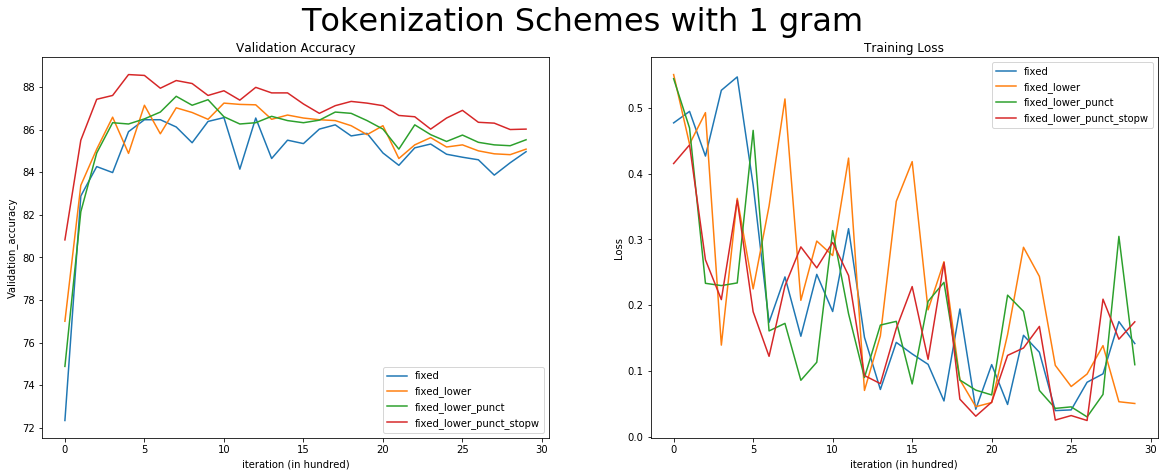

                                            fixed  fixed_lower  fixed_lower_punct  fixed_lower_punct_stopw
After_training_for_5_epochs_validation_acc   84.6        85.02              85.46                    86.04


In [595]:
plot_training_curve('token_scheme')

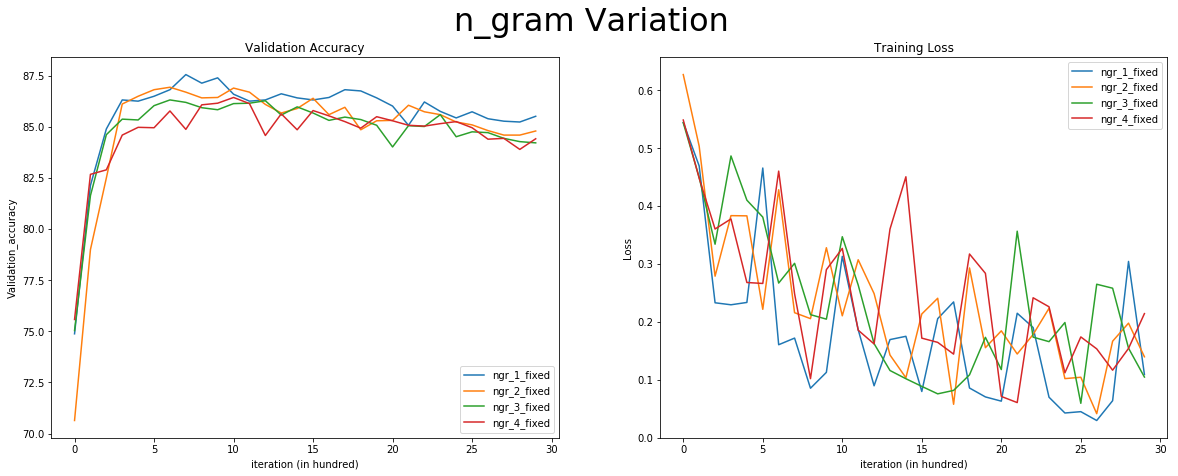

                                            ngr_1fixed  ngr_2fixed  ngr_3fixed  ngr_4fixed
After_training_for_5_epochs_validation_acc       85.46       85.22       84.16       84.48


In [600]:
plot_training_curve('n_grams')

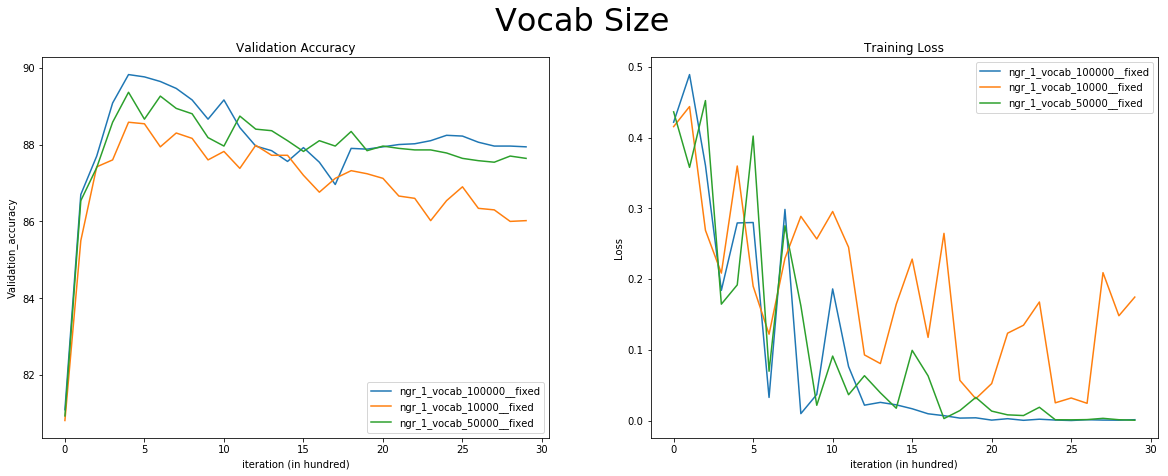

                                            ngr_1_vocab_100000_fixed  ngr_1_vocab_10000_fixed  ngr_1_vocab_50000_fixed
After_training_for_5_epochs_validation_acc                     87.96                    86.04                    87.58


In [613]:
plot_training_curve('vocab_size')

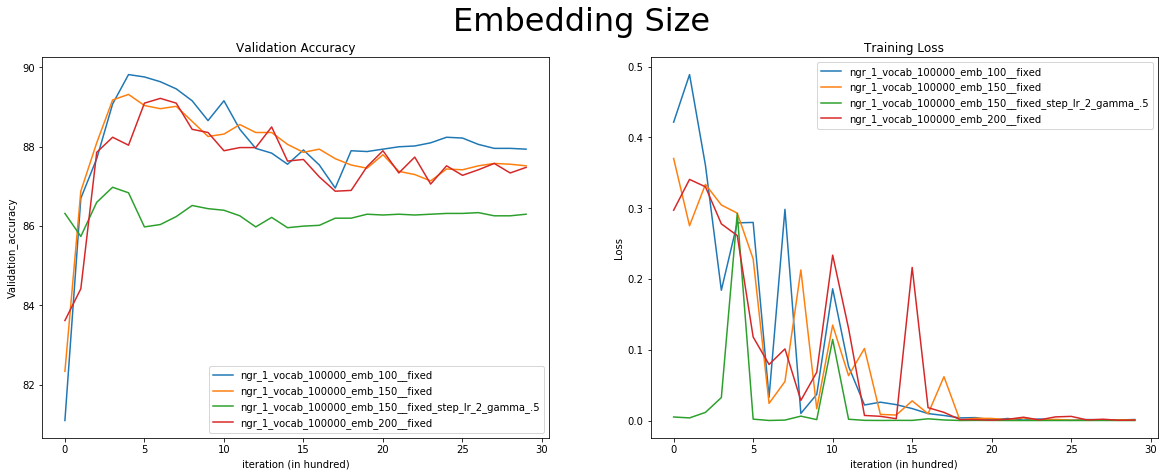

                                           _emb_100_fixed _emb_150_fixed _emb_150_fixed_step_lr_2_gamma_.5 _emb_200_fixed
After_training_for_8_epochs_validation_acc          87.96          87.44                             86.32          87.66


In [688]:
plot_training_curve('embedd_size')

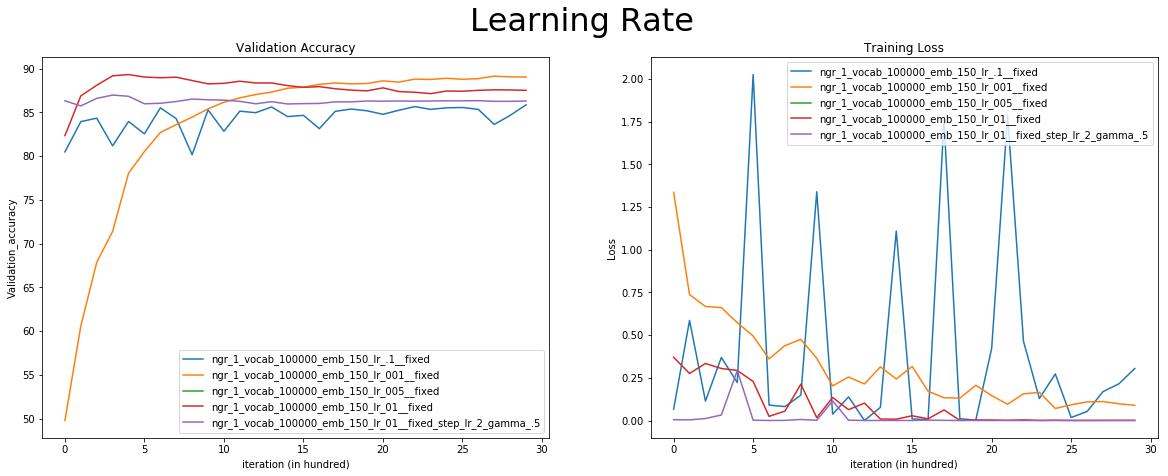

                                           .1_fixed 001_fixed 005_fixed 01_fixed 01_fixed_step_lr_2_gamma_.5
After_training_for_5_epochs_validation_acc    85.32     89.26     88.16    87.44                       86.32


In [662]:
plot_training_curve('learning_rate')

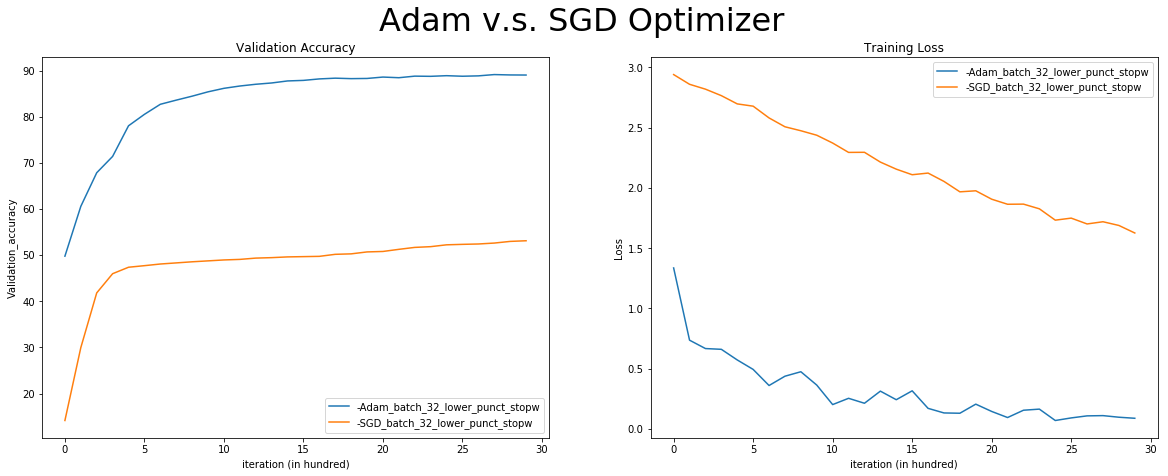

                                           fixedAdam_batch_32_lower_punct_stopw fixedSGD_batch_32_lower_punct_stopw
After_training_for_5_epochs_validation_acc                                89.26                               53.18


In [700]:
plot_training_curve('optimizer')

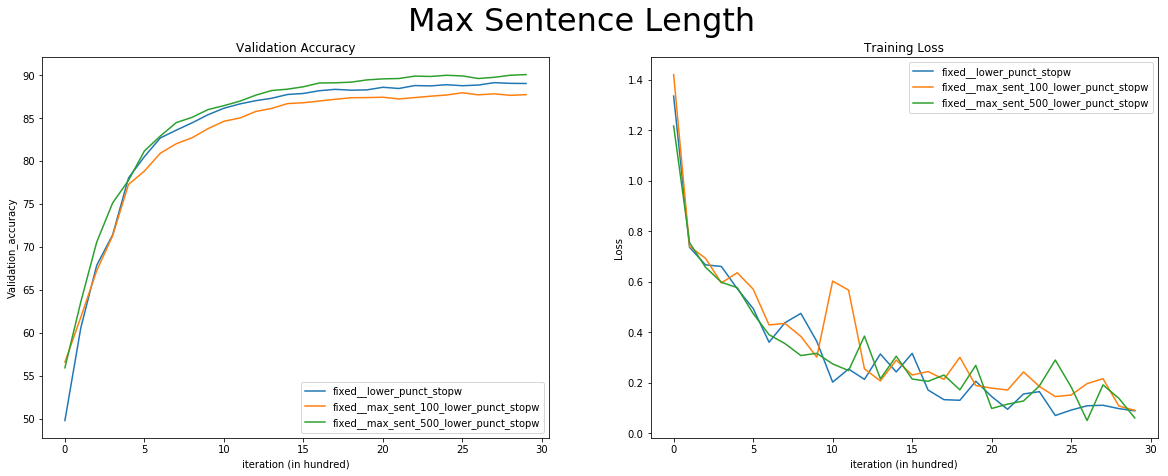

                                           _default _max_sent_100_default _max_sent_500_default
After_training_for_5_epochs_validation_acc    89.26                 87.72                 90.06


In [728]:
plot_training_curve('max_sentence')

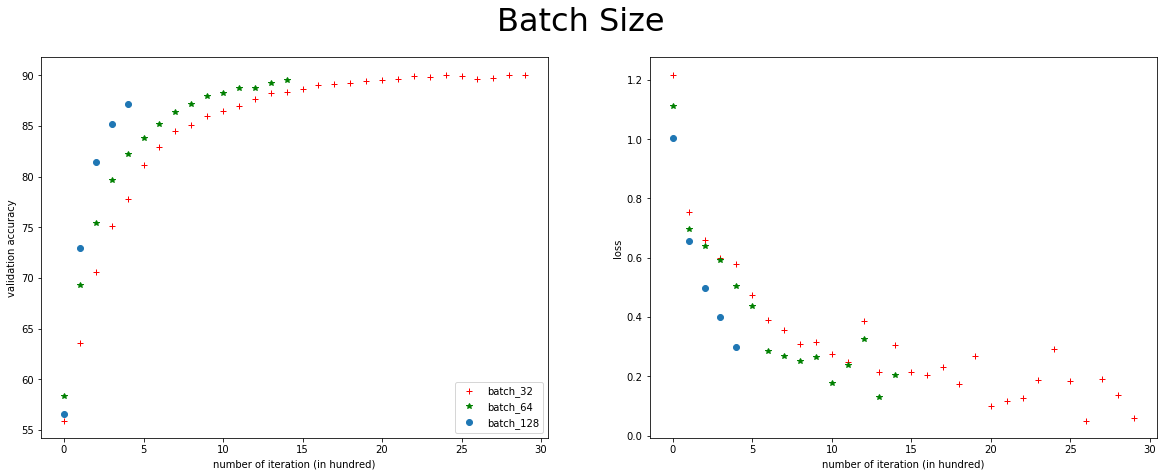

In [798]:
f = plt.figure(figsize=(20,7))
fixed = 'ngr_1_vocab_100000_emb_150_lr_001_epoch_5_Adam_'
keys = [key for key in after_train_val_acc.keys() if fixed in key 
       and 'max_sent_500_lower_punct_stopw' in key]
ax = f.add_subplot(121)
ax.plot(validation_acc_history.get(keys[0]),'k+',color='r', label = 'batch_32')
ax.plot(validation_acc_history.get(keys[1]),'*',color ='g', label = 'batch_64')
ax.plot(validation_acc_history.get(keys[2]),'o', label = 'batch_128')
ax.legend(loc=4)
ax.set_xlabel('number of iteration (in hundred)')
ax.set_ylabel('validation accuracy')
ax2 = f.add_subplot(122)
ax2.plot(loss_history.get(keys[0]),'k+',color='r', label = 'batch_32')
ax2.plot(loss_history.get(keys[1]),'*',color ='g', label = 'batch_64')
ax2.plot(loss_history.get(keys[2]),'o', label = 'batch_128')
ax2.set_xlabel('number of iteration (in hundred)')
ax2.set_ylabel('loss')
f.suptitle('Batch Size', fontsize=32)
plt.show()


Vary in batch size changes the number of iterations. When batch is 32, 600+ iterations every epoch, when batch is 64, only 300+iteration every epoch.


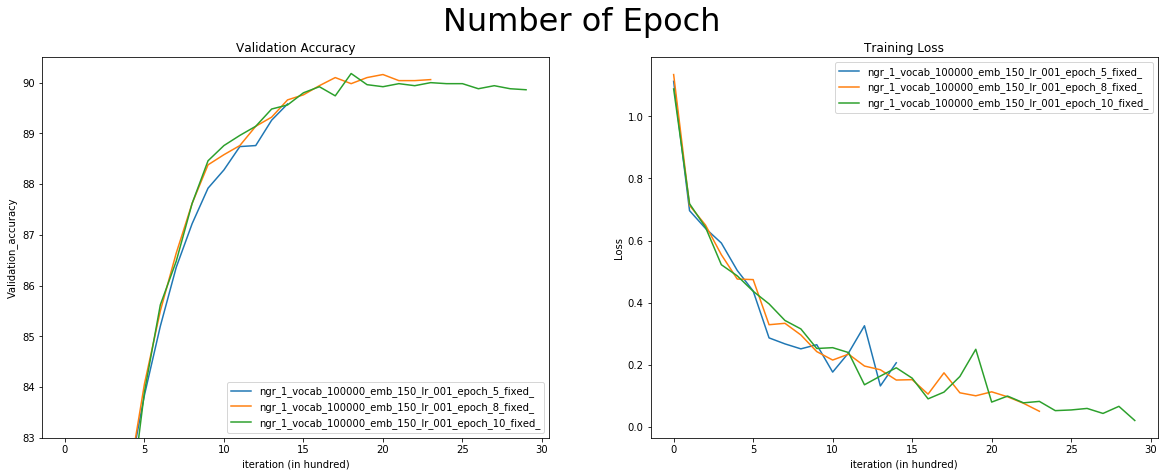

                                           _epoch_5_ _epoch_8_ _epoch_10_
After_training_for_5_epochs_validation_acc      89.5     90.02      89.82


In [793]:
plot_training_curve('epoch')

# choose best validation model

In [805]:
#choose best model having highest validation accuracy
best_setting = max(after_train_val_acc, key=after_train_val_acc.get)
print('best setting: {}'.format(best_setting))
print('highest validation accuracy: {}'.format(after_train_val_acc.get(best_setting)))

best setting: ngr_1_vocab_100000_emb_150_lr_001_epoch_8_Adam_batch_32_max_sent_500_lower_punct_stopw
highest validation accuracy: 90.2


In [814]:
val_acc, resultb = test_model(val_loader, model)
test_acc, _ = test_model(test_loader, model)

In [816]:
print ("Val Acc {}".format(val_acc))
print ("Test Acc {}".format(test_acc))

Val Acc 90.02
Test Acc 87.22


# Error Analysis

In [ ]:
#find the index where prediction =/!= labels, set shuffle = False for validation dataloader
label_value, predicted_value = zip(*result)
diff=[]
for i in range(len(label_value)-1):
    diff_value = label_value[i]-predicted_value[i].reshape(32,)
    diff+= list(diff_value)
    

In [948]:
correct_index = [i for i,val in enumerate(diff) if val==0][:3]
incorrect_index = [i for i,val in enumerate(diff) if val!=0][:3]

In [967]:
print('3 CORRECT predction on validation set')
print('\t')
for i in correct_index:
    print('True label is:', val_targets[i])
    print(val_data[i])
    print('\t')
    
    

3 CORRECT predction on validation set
	
True label is: 0
This movie is just plain terrible!!!! Slow acting, slow at getting to the point and wooden characters that just shouldn't have been on there. The best part was the showing of Iron Maiden singing in some video at a theater and thats it. the ending was worth watching and waiting up for but that was it!! The characters in this movie put me to sleep almost. Avoid it!!!
	
True label is: 0
Okay, what the hell kind of TRASH have I been watching now? "The Witches' Mountain" has got to be one of the most incoherent and insane Spanish exploitation flicks ever and yet, at the same time, it's also strangely compelling. There's absolutely nothing that makes sense here and I even doubt there ever was a script to work with, but somehow I couldn't turn it off. The scratching your head with confusion starts right away, with an opening sequence about an angry little girl that killed her mother's cat. So you think this film revolves on children pos

In [966]:
print('3 INCORRECT predctions on validation set')
print('\t')
for i in incorrect_index:
    print('True label:', val_targets[i])
    print(val_data[i])
    print('\t')
    

3 INCORRECT predctions on validation set
	
True label: 0
not your typical vamp story, not bram stoker or anne rice here. a truly original vampyre story. these vampyres are genetic mutants who the sunlight don't bother. they are pure evil to. <br /><br />the film is not perfect. many of the actors are clearly amateurs. the two leads who play van helsing and rally the vampyre chick are pretty good though. the film is intensely violent which may disturb some people. also it is loaded with scientific detail that many will find hard to understand and may get bored with. i was sold on the clever storyline and the couple good performances. no telling how successful this film could be if they had a bigger budget and it got mass distribution
	
True label: 0
Great CGI effects & a truly Oscar-worthy performance by Gary Sinise as Lt. Dan. <br /><br />Tom Hanks is a one-trick pony in this movie, how he got the Best Actor Oscar that year over Morgan Freeman was a crime. <br /><br />This movie is a p